In [1]:
from collections import defaultdict
import json
from glob import glob
from typing import Tuple

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import exp
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns

from statistics import kolmogorov_smirnov
from utils import load_samples_as_data_frame
from views import plot_distribution_comparison

mpl.rcParams['lines.linewidth'] = 2.5

# Base line variant distribution

In [2]:
normals, variants = load_samples_as_data_frame(glob('output/tumor_derived/*.json'))

In [3]:
def plot_distribution_with_peaks(seq, label=None):
    n = 5
    peak_constaints = {"width": 15, "distance": 50, "rel_height": 0.85}
    seq /= sum(seq)
    peaks, properties = find_peaks(seq.rolling(n).mean(), **peak_constaints)

    fragment_window = [50, 500]
    seq.plot(label=label, zorder=0)
    plt.plot(peaks, seq[peaks], "o", zorder=1)
    plt.hlines(
        y=properties["width_heights"],
        xmin=properties["left_ips"],
        xmax=properties["right_ips"],
        color="C1",
        zorder=2,
    )
    plt.xlim(fragment_window)

# Everything together


In [4]:
normals_pooled = normals.groupby("length (bp)").sum().sum(axis=1).astype(int)
variants_pooled = variants.groupby("length (bp)").sum().sum(axis=1).astype(int)

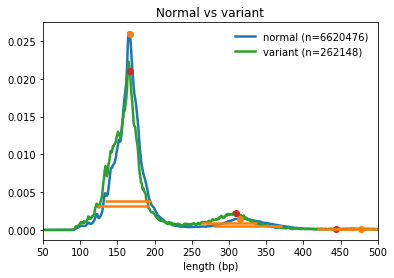

In [5]:
plt.title('Normal vs variant')
plot_distribution_with_peaks(normals_pooled, label=f'normal (n={normals_pooled.sum()})')
plot_distribution_with_peaks(variants_pooled, label=f'variant (n={int(variants_pooled.sum())})')
plt.legend(frameon=False)
plt.savefig('figs/normal_variant.png')

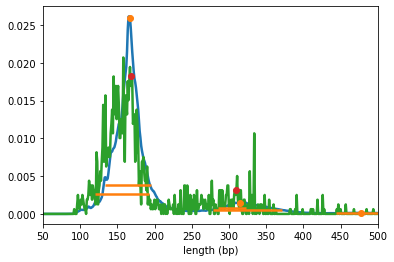

In [6]:
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['ROS1'])

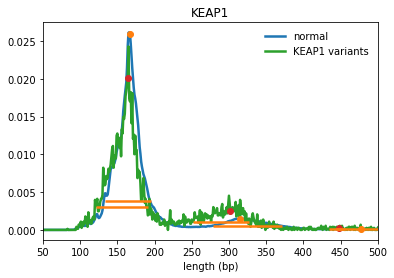

In [7]:
plt.title('KEAP1')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['KEAP1'], label='KEAP1 variants')
plt.legend(frameon=False)
plt.savefig('figs/keap1.png')

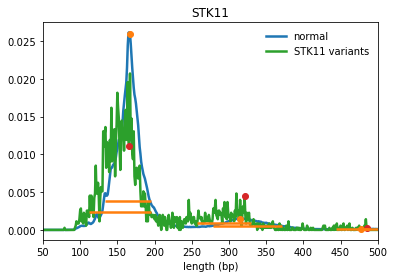

In [8]:
plt.title('STK11')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['STK11'], label='STK11 variants')
plt.legend(frameon=False)
plt.savefig('figs/stk11.png')

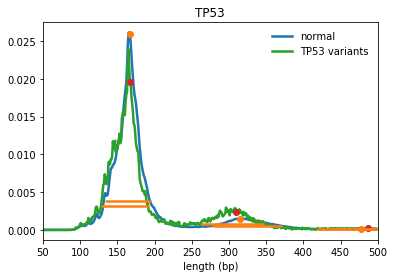

In [9]:
plt.title('TP53')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['TP53'], label='TP53 variants')
plt.legend(frameon=False)
plt.savefig('figs/tp53.png')

In [10]:
def compare_peak_shifts(variant_distribution, reference_distribution):
    """
    Calculate the peak position and width for each gene distribution, and compare to reference distributions.
    
    Focus on distributions that are statistically significant.
    """
    n = 5  # Number of base pair smoothing.
    peak_constaints = {'width': 15, 'distance': 80, 'rel_height': 0.85}
    ref_peaks, ref_properties = find_peaks(reference_distribution.rolling(n).mean(), **peak_constaints)
    
    def peak_shift(sequence, num_peaks=2):
        """ Calculate shift and broadening for given sequence. """
        peaks, props = find_peaks(sequence.rolling(n).mean(), **peak_constaints)
        max_peaks = min(num_peaks, len(peaks), len(ref_peaks))
       
        s1 = pd.Series({
            f'{peak_number+1}_shift': peaks[peak_number] - ref_peaks[peak_number]
            for peak_number in range(max_peaks)
        })
        print(s1.index)
        s2 = pd.Series({
            f'{peak_number+1}_broadening': props['widths'][peak_number] - ref_properties['widths'][peak_number]
            for peak_number in range(max_peaks)
        })
        return pd.concat([s1,s2])

    # Filter columns on statistical significance.
    significant_columns = tuple(
        c 
        for c in variant_distribution.columns 
        if kolmogorov_smirnov(reference_distribution, variant_distribution[c]) < 0.05
    )
    # Calculate shift for each gene.
    data_frame = pd.DataFrame(columns=significant_columns)
    for c in significant_columns:
        print(c)
        data_frame[c] = peak_shift(variant_distribution[c])
    return data_frame


In [11]:
df = compare_peak_shifts(variants, normals.sum(axis=1)).T

ABL1
Index(['1_shift', '2_shift'], dtype='object')
AKT2
Index(['1_shift', '2_shift'], dtype='object')
ALK
Index(['1_shift', '2_shift'], dtype='object')
APC
Index(['1_shift', '2_shift'], dtype='object')
AR
Index(['1_shift', '2_shift'], dtype='object')
ARAF
Index(['1_shift'], dtype='object')
BRAF
Index(['1_shift', '2_shift'], dtype='object')
BRCA1
Index(['1_shift', '2_shift'], dtype='object')
BRCA2
Index(['1_shift', '2_shift'], dtype='object')
CCND2
Index(['1_shift', '2_shift'], dtype='object')
CD274
Index(['1_shift', '2_shift'], dtype='object')
CDK4
Index(['1_shift', '2_shift'], dtype='object')
CDK6
Index(['1_shift', '2_shift'], dtype='object')
CDKN2A
Index(['1_shift', '2_shift'], dtype='object')
CSF1R
Index(['1_shift', '2_shift'], dtype='object')
CTNNB1
Index(['1_shift', '2_shift'], dtype='object')
DDR2
Index(['1_shift', '2_shift'], dtype='object')
EGFR
Index(['1_shift', '2_shift'], dtype='object')
ERBB2
Index(['1_shift', '2_shift'], dtype='object')
ESR1
Index(['1_shift', '2_shift'], d

In [12]:
def plot_peak(df, peak_number: int):
#     plt.figure(figsize=(4,3))
    plt.title(f'Peak {peak_number}')
    x_column = f'{peak_number}_shift'
    y_column = f'{peak_number}_broadening'
    xlim = (min(df[x_column])-2, max(df[x_column])+2)
    ylim = (min(df[y_column])-2, max(df[y_column])+2)
    plt.plot([0, 0], ylim, '-k', zorder=1, alpha=0.5)
    plt.plot(xlim, [0, 0], '-k', zorder=1, alpha=0.5)

    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.scatterplot(
        x=x_column, 
        y=y_column, 
        hue=df.index,
        data=df,
        zorder=2,
    )
    plt.ylabel('Broadening (bp)')
    plt.xlabel('Shift (bp)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


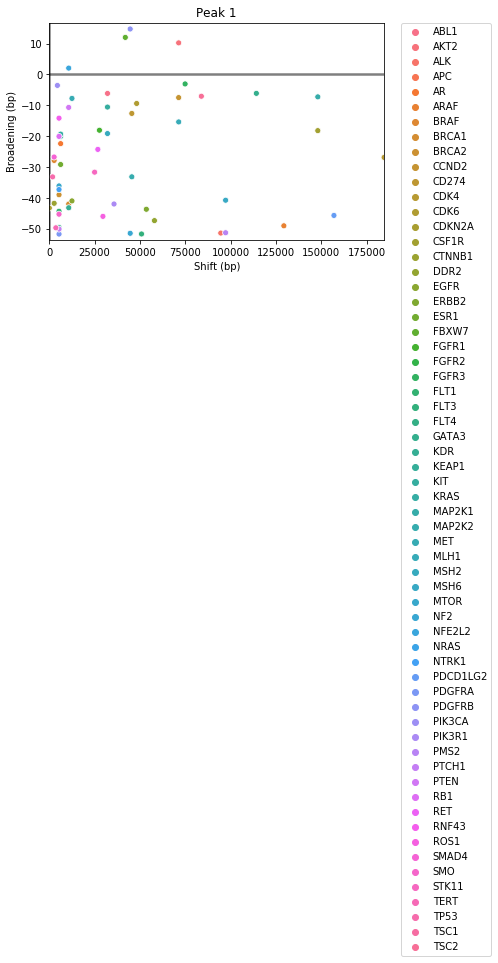

In [13]:
plot_peak(df, peak_number=1)
plt.savefig('figs/peak1.png', bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


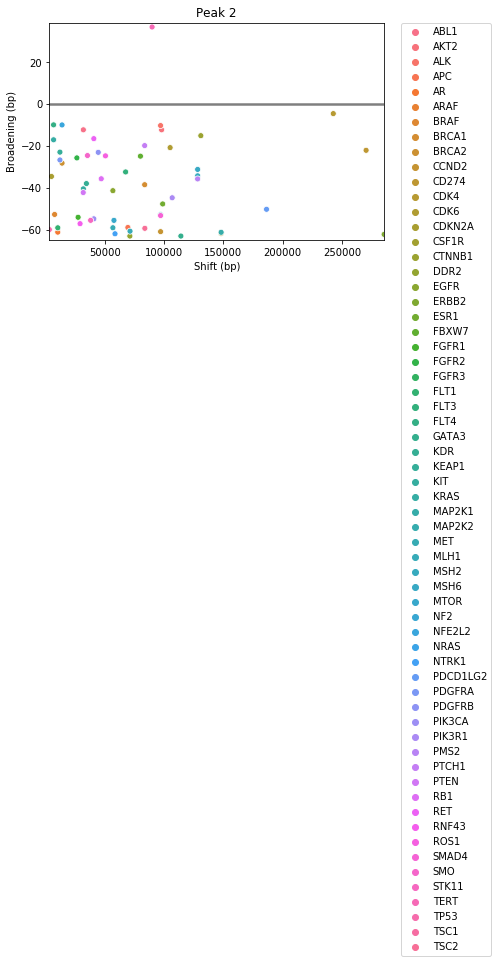

In [14]:
plot_peak(df, peak_number=2)
plt.savefig('figs/peak2.png', bbox_inches='tight')

[  4619   5517   6408   7305   7444  10864  11765  11913  12658  14437
  14586  15305  20660  26926  27074  27819  32261  32391  34958  35847
  36732  41199  41340  42068  44765  44908  45658  48335  51014  57253
  58146  59027  61715  61854  63498  67067  67219  67960  68105  71511
  71642  74203  75097  78661  80448  84013  84155  89367  90259  90402
  92043  92188  95613  95764  95913  97394  97537  98253  99160 105424
 105578 107189 109879 112558 112705 115238 115368 116126 116278 124156
 125920 127731 128615 128759 129499 130401 131271 131424 135754 136642
 136802 137535 137685 140211 141095 143779 143912 145561 148239 148372
 151806 152699 152826 154482 155376 156246 157142 157280 158944 162511
 162650 169648 170539 172324 174081 175000 176760 179443 181242 183031
 186585 189271 191053 205330 206219 206350 208901 209787 211571 211701
 212462 212615 218708 219584 221392 221534 222277 224950 225081 226716
 234761 234891 239220 239333 241007 241152 242798 242934 245471 245622
 24723

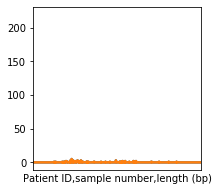

In [15]:
plt.figure(figsize=(3, 3))
from scipy.signal import find_peaks

seq = variants.sum(axis=1)
n = 5
peaks, properties = find_peaks(seq.rolling(n).mean(), width=15, distance=100)
print(peaks)
print(properties['widths'])
seq.plot()
seq.plot()
fragment_window = [50, 500]
plt.xlim(fragment_window)
plt.plot(peaks, seq[peaks], 'o')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

/home/donkerhc/avenio/fragment_count/views.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"figs/fragment_size_distribution_{filename_suffix}.png")


TypeError: ('1033', '0', 1) is not a string

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


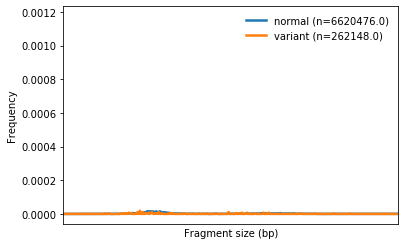

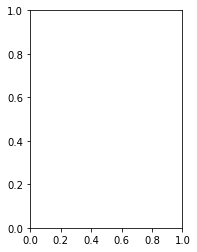

In [16]:
plot_distribution_comparison(normals.sum(axis=1), variants.sum(axis=1), filename_suffix='all')

In [ ]:
# for gene in normals.columns:
#     f = plt.figure(figsize=(8,3))
#     plt.title(gene)
#     plot_distribution_comparison(normals[gene], variants[gene])

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), variants['ABL1'], filename_suffix='EGFR')

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), normals['EGFR'], filename_suffix='EGFR')

In [ ]:
# Check that all normal genes are not significantly different.
significant_columns = tuple(
    c 
    for c in normals.columns 
    if kolmogorov_smirnov(normals.sum(axis=1), normals[c]) < 0.05/len(normals.columns)
)
significant_columns

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), normals['ROS1'])